# Adaptive Multilevel Delayed Acceptance - Predator Prey Model

## Import Modules

In [1]:
import os as os
import sys as sys
import time as time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt

import pandas as pd

from scipy.integrate import odeint # Used to Integrate System of Differential Equations

RANDOM_SEED = 1555
np.random.seed(RANDOM_SEED)

## Data: Lynx and Hare Pelts in Canada

Howard (2009) provides numerical data for the number of pelts collected by the Hudson’s Bay Company in the years 1900-1920, which we use as our data for the case study.

*Remark: Here, the number of pelts is rounded to the closest 100, building in measurement error on the order of 1%*



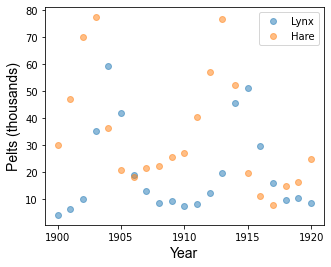

In [2]:
df = pd.read_csv('data/LynxHare.csv')


Data = df[["Lynx", "Hare"]].to_numpy()

Time = df[["Year"]].to_numpy()

axis_font = {'fontname':'Arial', 'size':'14'}

_, ax = plt.subplots(figsize=(5, 4))
ax.plot(Time,Data[:,0], "o", alpha = 0.5, label="Lynx")
ax.plot(Time,Data[:,1], "o", alpha = 0.5, label="Hare")

ax.set_xticks([1900, 1905, 1910, 1915, 1920])

ax.set_facecolor('w')
ax.set_ylabel("Pelts (thousands)", **axis_font)
ax.set_xlabel("Year", **axis_font)
ax.legend();
plt.savefig("LynxHare_data.pdf")

In [12]:
## Define level-Dependent Model Class

class LynxHare(tt.Op):

    # Specify what type of object will be passed and returned to the Op.
    itypes = [tt.dvector]  # expects a vector of parameter values when called
    otypes = [tt.dscalar]  # outputs a single scalar value (the log likelihood)
    
    def __init__(self, Data, Years, pymc3_model, level = -1):
        
        self.level = level
        
        sizeOfDataSets = [3, 11, 22]
        
        numericalTolerance = [0.1, 0.01, 0.001]
        
        self.Data = Data[0:sizeOfDataSets[level],:]
        
        self.t = Years[0:sizeOfDataSets[self.level]]
            
        self.rtol = numericalTolerance[level]
           
        
    def dX_dt(self,X, t, a, b, c, d):
        
        """ 
        Lotka Volterra Equations
        Given Parameters Returns the growth rate of fox and rabbit populations. 
        """

        return np.array([a * X[0] - b * X[0] * X[1], -c * X[1] + d * X[0] * X[1]])

    
    def perform(self, node, inputs, outputs):
        
        # the method that is used when calling the Op
        
        [a, c, b, d, sig, L0, H0] = inputs[0]  # this will contain my variables
        
        X0 = [L0, H0]
        
        X = odeint(self.dX_dt, y0=X0, t=self.t.flatten(), rtol=self.rtol, args=(a, b, c, d))
        
        misfit = np.log(X.flatten()) - np.log(self.Data.reshape(X.shape[0] * 2,1))
        
        logl = -np.mean(misfit**2) / (2.0 * (sig**2))
        
        outputs[0][0] = np.array(logl)  # output the log-likelihood


In [13]:
## Build Hierarchy of PyMC3 Models

logl = []
modelHierarchy = []

maxLevel = 3

for j in range(maxLevel):

    with pm.Model() as model:

        # Define priors
        a = pm.Normal('a', mu= 1.0, sigma=0.5)
        c = pm.Normal('c', mu= 1.0, sigma=0.5)
        b = pm.Normal('b', mu=0.05, sigma=0.05)
        d = pm.Normal('d', mu=0.05, sigma=0.05)
        sig = pm.Lognormal('sig', mu=-1.0, sigma = 1.0)
        L0 = pm.Lognormal('L0', mu=np.log(10), sigma = 1.0)
        H0 = pm.Lognormal('H0', mu=np.log(10), sigma = 1.0)

        # wrap parameters to tensor vector
        theta = tt.as_tensor_variable([a, c, b, d, sig, L0, H0])

        # Build instances of "BodyFat" class for level j
        logl.append(LynxHare(Data, Time, model, j))

        pm.Potential('likelihood', logl[j](theta))

        modelHierarchy.append(model)

In [17]:
numSamples = 2000
numChains = 2
numCores = 1
burnIn = 1000
subSampling = [10,5]

with modelHierarchy[-1]: # with the finest level model
    
    step = pm.MLDA(coarse_models=[modelHierarchy[0], modelHierarchy[1]],
                   subsampling_rates=subSampling)
    
    trace = pm.sample(draws=numSamples, chains=numChains, cores = numCores, tune=burnIn, step=step, discard_tuned_samples=True,
                   random_seed=RANDOM_SEED)

/Users/td336/Dropbox/pymc3/pymc3/step_methods/mlda.py:453: UserWarning: The MLDA implementation in PyMC3 is very young. You should be extra critical about its results.
  warnings.warn(


/Users/td336/miniconda3/envs/pymc3_env/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [18]:
pm.stats.summary(trace)

/Users/td336/miniconda3/envs/pymc3_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.078,0.434,0.273,1.874,0.008,0.006,2811.0,2811.0,2735.0,2070.0,1.0
c,1.073,0.433,0.294,1.870,0.009,0.006,2335.0,2335.0,2326.0,3250.0,1.0
b,0.063,0.036,0.001,0.126,0.001,0.000,3016.0,3016.0,2986.0,2193.0,1.0
d,0.064,0.037,0.001,0.128,0.001,0.000,2959.0,2870.0,3038.0,3131.0,1.0
sig,1.925,1.466,0.386,4.377,0.027,0.019,2904.0,2904.0,2415.0,1951.0,1.0
L0,15.530,14.896,0.376,40.934,0.268,0.190,3089.0,3089.0,2971.0,3185.0,1.0
H0,15.581,16.473,0.502,40.359,0.308,0.218,2861.0,2861.0,2996.0,3125.0,1.0


/Users/td336/miniconda3/envs/pymc3_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13ac671f0>,
      dtype=object)

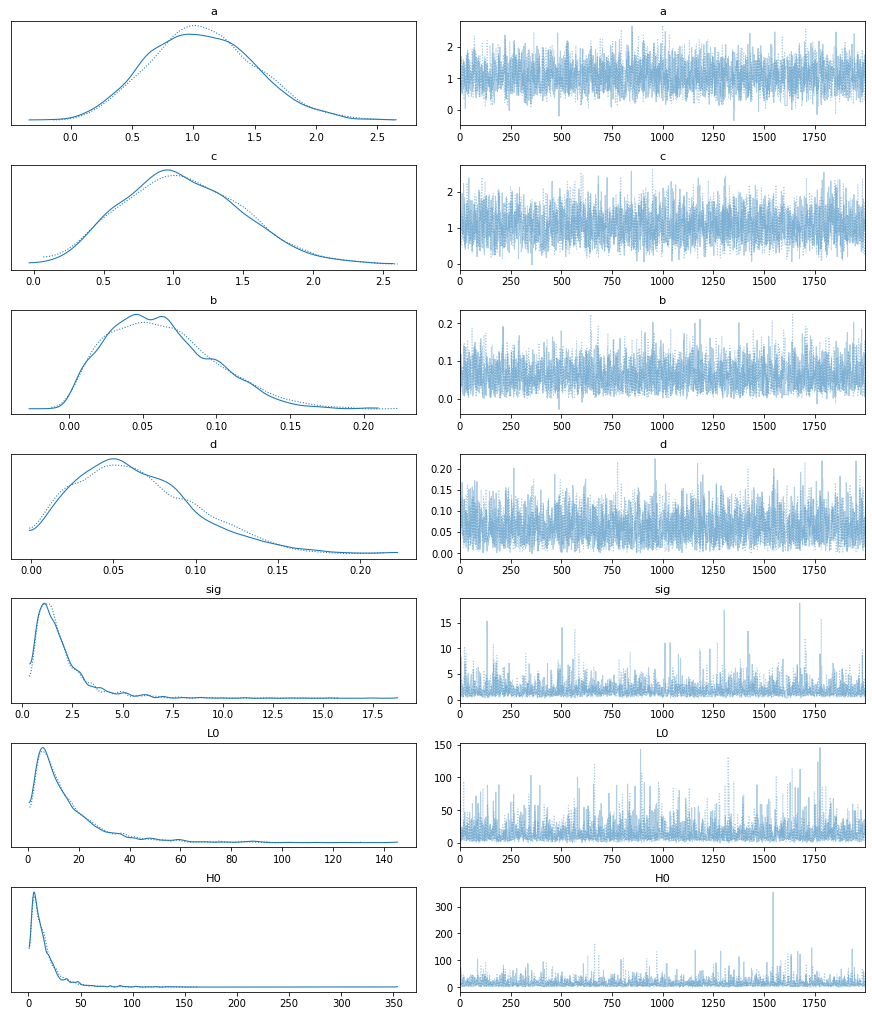

In [19]:
pm.plots.traceplot(trace)